# Explore here

General Imports

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from imutils import paths
import imghdr
import cv2
import os


from matplotlib.image import imread

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.optimizers.legacy import Adam

from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image

In [2]:
'''zip_files = [
    {'zip_file': '~/.kaggle/dogs-vs-cats.zip'},
    {'zip_file': '~/Documents/Bootcamp/image_classifier_project/data/raw/test1.zip'},
    {'zip_file': '~/Documents/Bootcamp/image_classifier_project/data/raw/train.zip'}
]
extract_to_path = '~/Documents/Bootcamp/image_classifier_project/data/raw'

if not os.path.exists(extract_to_path):
    os.makedirs(extract_to_path)

for zip_info in zip_files:
    zip_file_path = zip_info['zip_file']
    
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
'''

"zip_files = [\n    {'zip_file': '~/.kaggle/dogs-vs-cats.zip'},\n    {'zip_file': '~/Documents/Bootcamp/image_classifier_project/data/raw/test1.zip'},\n    {'zip_file': '~/Documents/Bootcamp/image_classifier_project/data/raw/train.zip'}\n]\nextract_to_path = '~/Documents/Bootcamp/image_classifier_project/data/raw'\n\nif not os.path.exists(extract_to_path):\n    os.makedirs(extract_to_path)\n\nfor zip_info in zip_files:\n    zip_file_path = zip_info['zip_file']\n    \n    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:\n        zip_ref.extractall(extract_to_path)\n"

In [4]:
img_height = 200
img_width = 200
batch_size = 4

Load data using a Keras utility

In [5]:
main_directory = "/Documents/Bootcamp/image_classifier_project/data/raw/train"
training_dataset = image_dataset_from_directory(main_directory,
                        labels="inferred",
                        class_names=["cats","dogs"],
                        image_size=(img_height,img_width),
                        validation_split=0.1,
                        seed = 123,
                        subset="training",
                        batch_size=batch_size)

validation_dataset = image_dataset_from_directory(main_directory,
                        labels="inferred",
                        class_names=["cats","dogs"],
                        image_size=(img_height,img_width),
                        validation_split=0.1,
                        seed = 123,
                        subset="validation",
                        batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 22500 files for training.


2024-09-22 15:11:13.337417: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-22 15:11:13.337448: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-22 15:11:13.337453: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-22 15:11:13.337664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-22 15:11:13.337689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 25000 files belonging to 2 classes.
Using 2500 files for validation.


In [6]:
class_names = training_dataset.class_names
print(class_names)

['cats', 'dogs']


Visualize the data

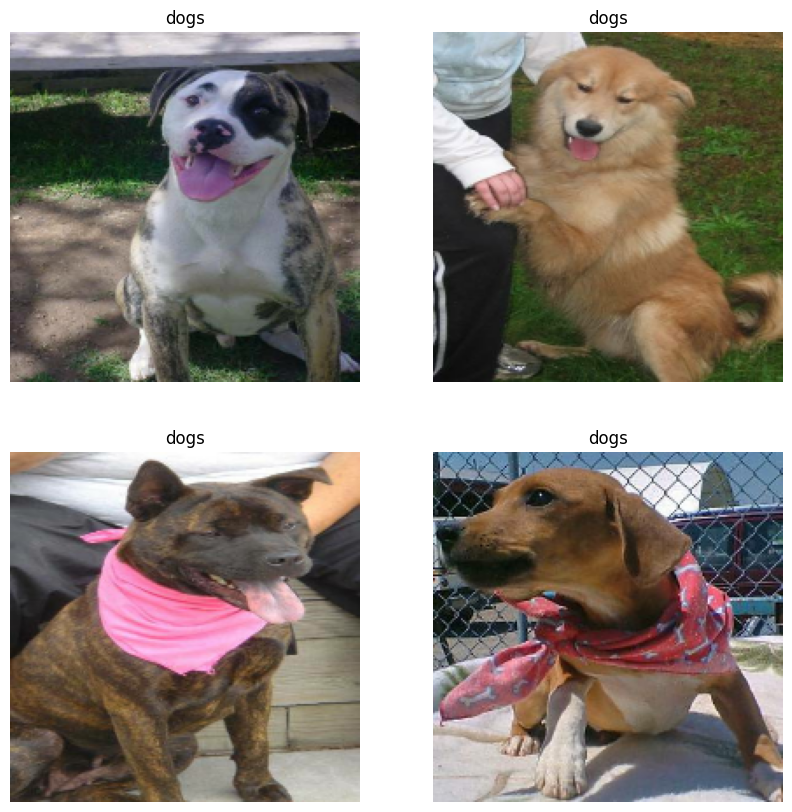

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in training_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 200, 200, 3)
(4,)


Cache for performance

In [9]:
AUTOTUNE=tf.data.AUTOTUNE

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

`layers.Rescaling` was added for this purpose

In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.25),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer=Adam(learning_rate=0.000002),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 200, 200, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      3

In [13]:
#function that train the model
epochs=10
history = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10


2024-09-22 15:11:15.281042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5624/5625 [============================>.] - ETA: 0s - loss: 1.3750 - accuracy: 0.6116

2024-09-22 15:14:36.401856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5625/5625 [==============================] - 209s 37ms/step - loss: 1.3748 - accuracy: 0.6116 - val_loss: 1.1821 - val_accuracy: 0.6580
Epoch 2/10
5625/5625 [==============================] - 236s 42ms/step - loss: 0.9033 - accuracy: 0.7026 - val_loss: 1.0715 - val_accuracy: 0.6636
Epoch 3/10
5625/5625 [==============================] - 249s 44ms/step - loss: 0.6501 - accuracy: 0.7660 - val_loss: 1.2371 - val_accuracy: 0.6636
Epoch 4/10
5625/5625 [==============================] - 254s 45ms/step - loss: 0.4399 - accuracy: 0.8321 - val_loss: 1.0806 - val_accuracy: 0.6776
Epoch 5/10
5625/5625 [==============================] - 252s 45ms/step - loss: 0.2802 - accuracy: 0.8896 - val_loss: 1.2619 - val_accuracy: 0.6804
Epoch 6/10
5625/5625 [==============================] - 247s 44ms/step - loss: 0.1752 - accuracy: 0.9330 - val_loss: 1.4371 - val_accuracy: 0.6796
Epoch 7/10
5625/5625 [==============================] - 239s 43ms/step - loss: 0.1133 - accuracy: 0.9599 - val_loss: 1.3693 - val

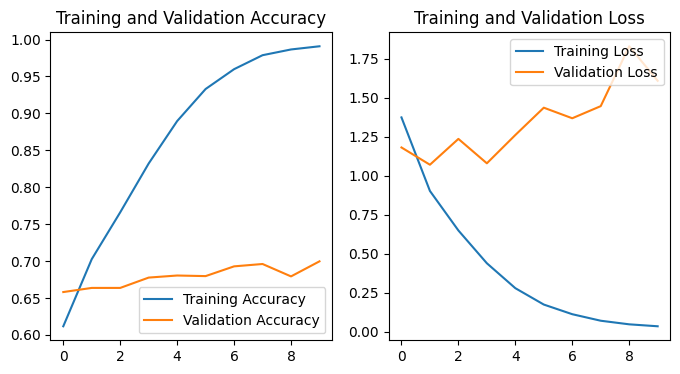

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
img = tf.keras.utils.load_img(
    '/Users/nandapop/Documents/Bootcamp/image_classifier_project/data/raw/test1/5.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions[0])

score = tf.nn.softmax(predictions[0])
print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

2024-09-22 15:51:14.902848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 924ms/step
[ 6.1847935  -0.35116473]
tf.Tensor([0.9985518  0.00144824], shape=(2,), dtype=float32)
This image most likely belongs to cats with a 99.86 percent confidence.
